# Large-scale Distributed $k$-means Algorithm

___

**Martin GUYARD, https://github.com/9OP**

___


In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


#### Preamble code

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
from sklearn import datasets
import time

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [2]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

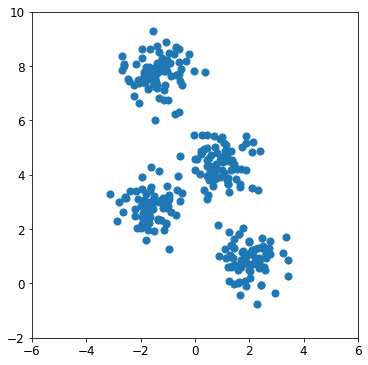

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of k-means, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> Print the number of data points that belong to each cluster</li>
    <li> Plot the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

<br>

**Answer:**
___

In [4]:
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids...
    N = X.shape[0] # number of data points
    np.random.seed(seed) # seed to replicate results
    rand_indices = np.random.choice(N, k, replace=False) # random indices for centroids init
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        # distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        distance_matrix = np.empty((N, k))
        for i in range(N):
            data_point = X[i]
            for j in range(k):
                centroid = centroids[j]
                distance_matrix[i, j] = euclidean(data_point, centroid)
                
        # assign each data point to the closest centroid
        # cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        cluster_assignment = np.empty((N, 1))
        for i in range(N):
            min_index = np.argmin(distance_matrix[i]) # index of min 
            cluster_assignment[i] = min_index
                
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.zeros((k, 2))
        for centroid in range(k):
            indexes = np.argwhere(cluster_assignment==centroid)[::, 0]
            new_centroid = np.array((X[indexes][::, 0].mean(), X[indexes][::, 1].mean()))
            new_centroids[centroid] = new_centroid

        # STOP CONDITION
        # if centroids == new_centroids => stop
        if (centroids == new_centroids).all():
            break
        else:
            centroids = new_centroids
    
    return centroids, cluster_assignment



def plot_clusters(centroids, X, clusters, title=''):
    plt.rcParams['figure.figsize'] = 8,6 
    plt.rcParams["legend.loc"] = 'best'
    
    xmin, xmax = X[::, 0].max()*1.2, X[::, 0].min()*1.2
    ymin, ymax = X[::, 1].max()*1.2, X[::, 1].min()*1.2
    k = centroids.shape[0] # number of clusters
    
    # Clusters
    for i in range(k):
        indexes = np.argwhere(clusters==i)[::, 0]
        cluster_size = indexes.size
        plt.scatter(X[indexes][::, 0], X[indexes][::, 1], 
                    label='Cluster '+str(i)+' | Size '+str(cluster_size), s=20)
    
    # Centroids
    plt.scatter(centroids[::, 0], centroids[::, 1], color='black', label='Centroids', s=50)
#     plt.scatter(initial_centroids[::, 0], initial_centroids[::, 1], 
#                 label='Initial centroids', s=50)
    
    plt.title(title)
    plt.ylim(ymax, ymin)
    plt.xlim(xmax, xmin)
    plt.legend(frameon=False, loc='best', bbox_to_anchor=(1.5, 1))
    plt.show()

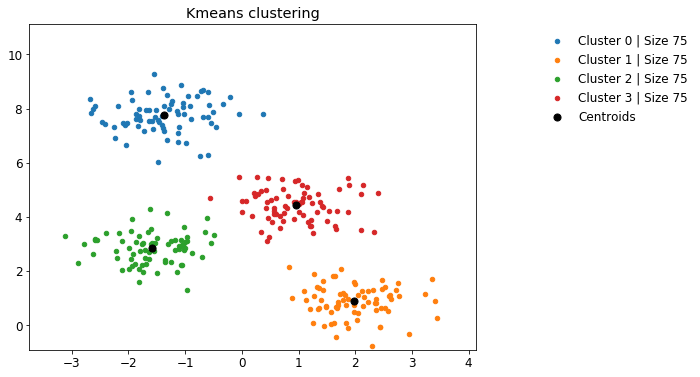

In [5]:
centroids, clusters = kmeans(X, 4, 1000, seed=1) # seed=0 bad clusters, seed=1 good clusters
plot_clusters(centroids, X, clusters, title='Kmeans clustering')

<div class="alert alert-block alert-success">    
<b>Note:</b> With seed=1 the clustered data is relevant, but with seed=0 the clustering is bad. Kmeans result is closely closely tied up with the initialization of the centroids. If they are poorly initialized (seed=0) then the algorithm converge toward a local minimum with misclassified data in our clusters.
</div>

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Use the built-in k-means implementation in sklearn and determine centroids and clusters.

Follow the guidelines below:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of your cell should contain the following information:
<ul>
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

<br>

**Answer:**
___

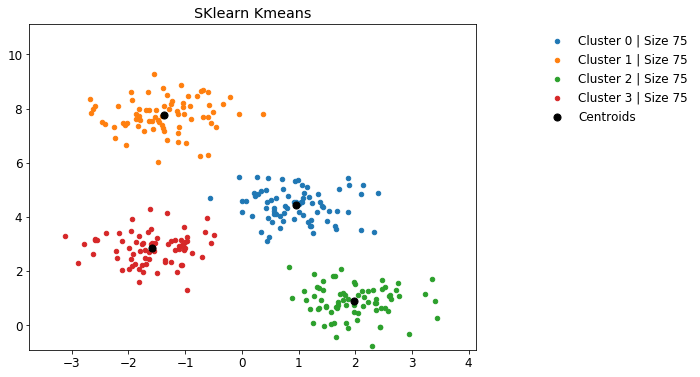

In [6]:
kmeans_clf = KMeans(n_clusters=4).fit(X)
clusters = kmeans_clf.predict(X)
centroids = kmeans_clf.cluster_centers_

plot_clusters(centroids, X, clusters, title='SKlearn Kmeans')

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation.

Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


The output of your cell should contain the following information:
<ul>
    <li> Plot the new synthetic dataset you generated
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

<br>

**Answer:**
___

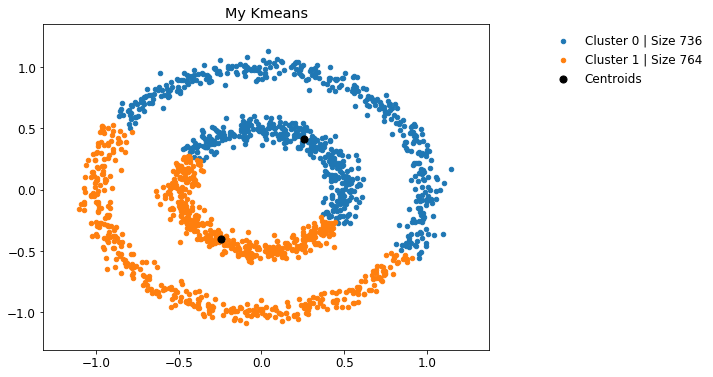

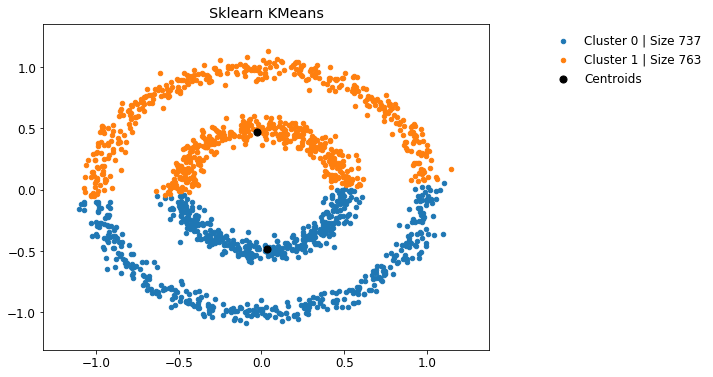

In [7]:
X1, y1 = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)

centroids, clusters = kmeans(X1, k=2, maxiter=1000)
plot_clusters(centroids, X1, clusters, title='My Kmeans')

kmeans_clf = KMeans(n_clusters=2).fit(X1)
clusters, centroids = kmeans_clf.predict(X1), kmeans_clf.cluster_centers_
plot_clusters(centroids, X1, clusters, title='Sklearn KMeans')

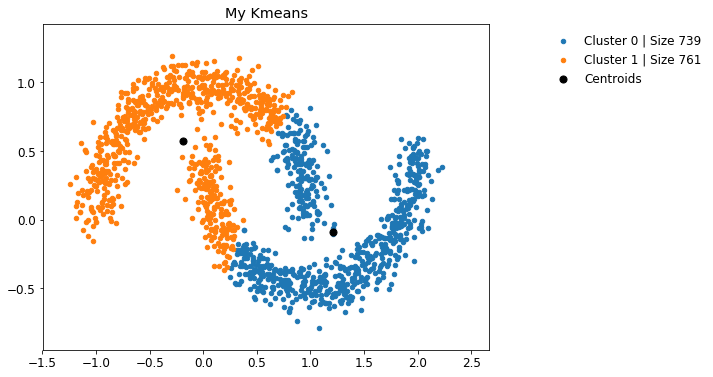

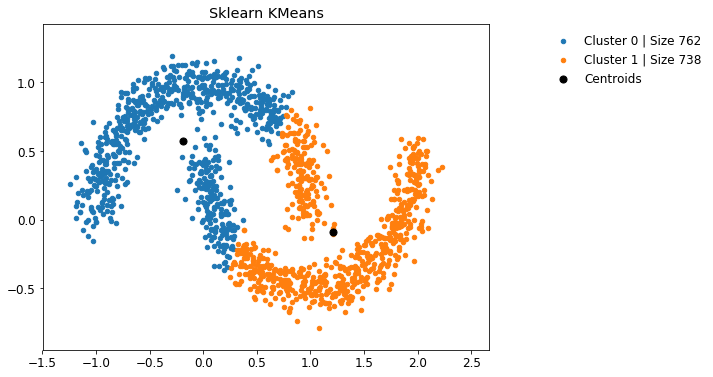

In [8]:
X2, y2 = datasets.make_moons(n_samples=1500, noise=.1)

centroids, clusters = kmeans(X2, k=2, maxiter=1000)
plot_clusters(centroids, X2, clusters, title='My Kmeans')

kmeans_clf = KMeans(n_clusters=2).fit(X2)
clusters, centroids = kmeans_clf.predict(X2), kmeans_clf.cluster_centers_
plot_clusters(centroids, X2, clusters, title='Sklearn KMeans')

<br>
<br>

***

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Modify your own version of k-means, to compute heterogeneity as defined above.

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

**Answer:**
___

In [19]:
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    N = X.shape[0] # number of data points
    np.random.seed(seed) # seed to replicate results
    rand_indices = np.random.choice(N, k, replace=False) # random indices for centroids init
    centroids = X[rand_indices]

    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        # distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        distance_matrix = np.empty((N, k))
        for i in range(N):
            data_point = X[i]
            for j in range(k):
                centroid = centroids[j]
                distance_matrix[i, j] = euclidean(data_point, centroid)
                
        # assign each data point to the closest centroid
        # cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        cluster_assignment = np.empty((N, 1))
        for i in range(N):
            min_index = np.argmin(distance_matrix[i]) # index of min 
            cluster_assignment[i] = min_index
                
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.zeros((k, 2))
        for centroid in range(k):
            indexes = np.argwhere(cluster_assignment==centroid)[::, 0]
            new_centroid = np.array((X[indexes][::, 0].mean(), X[indexes][::, 1].mean()))
            new_centroids[centroid] = new_centroid

        # STOP CONDITION
        # if centroids == new_centroids => stop
        if (centroids == new_centroids).all():
            break
        else:
            centroids = new_centroids
    
    # COMPUTE HETEROGENEITY
    heterogeneity = 0
    for centroid in range(k):
        indexes = np.argwhere(cluster_assignment==centroid)[::, 0]
        for x in X[indexes]:
            heterogeneity += euclidean(centroids[centroid], x)
            
    return centroids, cluster_assignment, heterogeneity

___

<br>

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.

Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

Add your personal comment about the convergence properties of the $k$-means algorithm.

</div>

<br>

**Answer**:
___

In [21]:
seeds = np.random.randint(1,100, size=(1, 10))[0]
# seeds = range(50)

def heterogeneity(seeds, kmeans, k=4, verbose=True):
    heterogeneity_map = {}
    baseline = 0
    for seed in seeds:
        _, _, heterogeneity = kmeans(X, k, 1000, seed=seed)
        heterogeneity_map[seed] = heterogeneity
        baseline += heterogeneity
    baseline /= len(seeds)
    
    if verbose:
        print('{:<10}  {:<10}'.format('Seed:', 'Heterogeneity:'))
        for seed, heterogeneity in heterogeneity_map.items():
            print('{:<10}  {:<10}'.format(seed, heterogeneity))
    
        print('Baseline:', baseline)
    return baseline
    
heterogeneity(seeds, kmeans)

Seed:       Heterogeneity:
52          222.89386306068852
71          345.57647474655147
94          222.89386306068866
98          222.89386306068874
45          222.8938630606887
90          222.89386306068897
54          345.0248724765334
38          341.2491079096944
Baseline: 259.21074965576


259.21074965576

<div class="alert alert-block alert-success">  
<b>Note:</b> The K-means algorithm seems to always converge for a well clustered dataset (not necessarily with the same number of iterations) but the results depends on the initialization. With some seed values the algorithm get stuck in a local minimum. The result relies a lot on randomness of initialization of centroids. With different seeds=different initialization, the heterogeneity is different.
<br>
<br>
<b>Baseline(average):</b> 250
<br>
<br>
<b>I suspect that the Sklean KMeans compute an heterogeneity score for several seed and return the result with the lowest heterogeneity score, since the Sklearn KMeans always return the right clustering compared to my implementation.</b>
</div>

___

<br>

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm

...very very very * inf unclear explanations, a pseudo code would be better, the steps doesn't even make sense... thk for wasting 3h

<div class="alert alert-block alert-info">
<strong>Question 6.</strong> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric.

<br>
<br>

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

<br>

**Answer:**
___

In [11]:
def init_centroids(X, k, plot=False):
    """
    K-means++ init algorithm, return initalized centroids array
    """
    N = X.shape[0]
    d = X.shape[1] # dimension of data (#feature)
    centroids = []
    centroids.append(X[np.random.randint(0, N)]) # init first centroid
    
    if plot:
        plt.rcParams['figure.figsize'] = 4, 3 
        fig = plt.figure()
        plt.scatter(X[::, 0], X[::, 1])
        plt.scatter(centroids[0][0], centroids[0][1])

    for c_ in range(k-1):
        distances = np.empty((N, 1))
        for i in range(N):
            dist = euclidean(X[i], centroids[0]) 
            for j in range(len(centroids)): 
                temp_dist = euclidean(X[i], centroids[j]) 
                dist = min(dist, temp_dist) 
            distances[i] = dist
        
        next_centroid = X[np.argmax(distances)] 
        centroids.append(next_centroid) 
        
        if plot:
            fig = plt.figure()
            plt.scatter(X[::, 0], X[::, 1])
            plt.scatter(next_centroid[0], next_centroid[1]) 

    return np.array(centroids)



def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    N = X.shape[0] # number of data points
    np.random.seed(seed) # seed to replicate results
    centroids = init_centroids(X, k)

    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        # distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        distance_matrix = np.empty((N, k))
        for i in range(N):
            data_point = X[i]
            for j in range(k):
                centroid = centroids[j]
                distance_matrix[i, j] = euclidean(data_point, centroid)
                
        # assign each data point to the closest centroid
        # cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        cluster_assignment = np.empty((N, 1))
        for i in range(N):
            min_index = np.argmin(distance_matrix[i]) # index of min 
            cluster_assignment[i] = min_index
                
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.zeros((k, 2))
        for centroid in range(k):
            indexes = np.argwhere(cluster_assignment==centroid)[::, 0]
            new_centroid = np.array((X[indexes][::, 0].mean(), X[indexes][::, 1].mean()))
            new_centroids[centroid] = new_centroid

        # STOP CONDITION
        # if centroids == new_centroids => stop
        if (centroids == new_centroids).all():
            break
        else:
            centroids = new_centroids
    
    # COMPUTE HETEROGENEITY
    heterogeneity = 0
    for centroid in range(k):
        indexes = np.argwhere(cluster_assignment==centroid)[::, 0]
        for x in X[indexes]:
            heterogeneity += euclidean(centroids[centroid], x)
            
    return centroids, cluster_assignment, heterogeneity

array([[-1.7578319 ,  2.97449321],
       [-1.5499458 ,  9.28293222],
       [ 3.43761754,  0.26165417],
       [ 2.40615694,  4.87047502]])

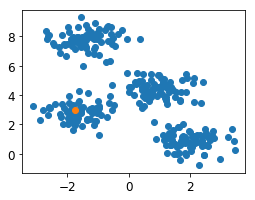

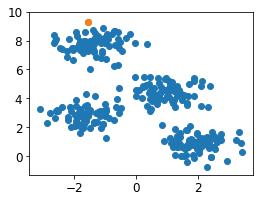

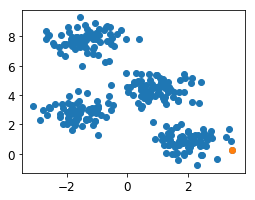

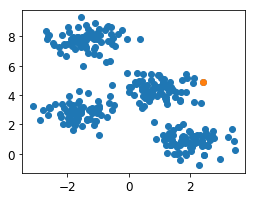

In [12]:
init_centroids(X, 4, plot=True) 

<div class="alert alert-block alert-success">
<b>Note:</b> Kmeans++ is working as it should, we see on the plot that the centroids init is always the farther away from the already initialized centroids. This is great! **BUT** We still have to rely on the first random initialization
</div>
___

<br>

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.
</div>

<br>

**Answer:**
___

In [13]:
seeds = np.random.randint(1,1000, size=(1, 5))[0]
heterogeneity(seeds, kmeans)

Seed:       Heterogeneity:
927         222.89386306068872
114         222.8938630606887
977         222.8938630606887
2           222.89386306068872
579         222.89386306068857
Baseline: 222.8938630606887


222.8938630606887

<div class="alert alert-block alert-success">
<b>Baseline(average):</b> 222
<br>
<b>Baseline heterogeneity score is better with Kmeans++ than with Kmeans.</b> Kmeans++ perform better on average. The centroids are not chosen randomly anymore, but chosen to be clearly separated. It was expected, and it is working nicely. This improvement ensure consistency in the results on several runs. Only one centroids is initialized randomly now, all the others are computed to be the farthest away from one another.
</div>
<br>
<br>


***

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

<br>

**Answer:**
___

In [14]:
seeds = np.random.randint(1,100, size=(1, 20))[0]

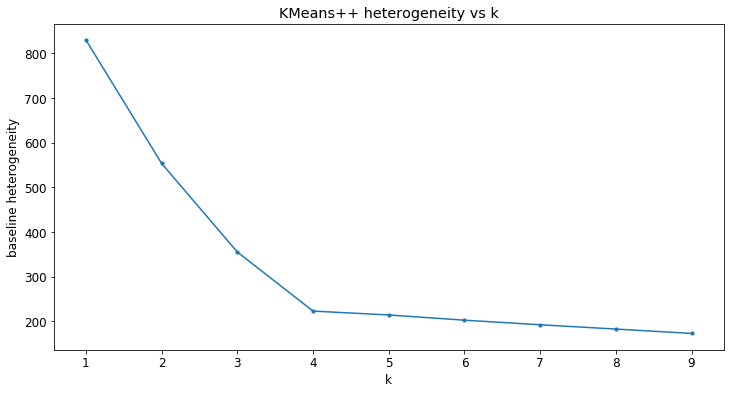

In [16]:
ks, hete = range(1, 10), []
seeds = np.random.randint(1,100, size=(1, 5))[0]

for k in ks:
    baseline = heterogeneity(seeds, kmeans, k, verbose=False)
    hete.append(baseline)
    
plt.rcParams['figure.figsize'] = 12, 6
fig = plt.figure()
plt.plot(ks, hete)
plt.scatter(ks, hete, s=10)
plt.title('KMeans++ heterogeneity vs k')
plt.ylabel('baseline heterogeneity')
plt.xlabel('k')
plt.show()
fig.savefig('heterogeneity_vs_k.png')

<div class="alert alert-block alert-success">
<b>Note:</b> I plot the baseline heterogeneity for several seeds vs several value of k. The plot confirms our expected results, the baseline heterogeneity curve "breaks" at k=4, confirming there are 4 clusters. 
The more clusters there are the less the heterogeneity is because points are less likely to be far from their assigned centroid. But from k=4 the heterogeneity decrease slower than it used to between k=1 and k=3. 
</div>
<br>
<br>

***

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

By now, you should be rather familiar with the $k$-means algorithm, which means we can focus on its parallel and distributed design.

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, you need to figure out how to implement the ```assignement_step``` function and the update_step function. For the latter, the pseudo code gives you a big hint! Remember what we discussed in class about computing the mean!

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

Your output cell should contain:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>
</div>

**Answer:**
___

In [22]:
def distributed_kmeans(datapoints, k, maxiter=100, partitions=6, seed=None):
    def assignement_step(data):
        '''
        compute the distance between each data point and each centroid, 
        to assign data points to their closest centroid.
        '''
        closest = lambda point: np.argmin([euclidean(point, centroid) for centroid in bcCentroids.value])
    
        for point in data:
            # compute distance to centroids
            cluster = closest(point)
            # return closest centroids
            yield (cluster, [point])
   

    np.random.seed(seed) # seed to replicate results
    
    N = datapoints.shape[0] # number of data points
    rand_indices = np.random.choice(N, k, replace=False) # random indices for centroids init
    
    rdd_datapoints = sc.parallelize(datapoints, partitions)#.cache()
    centroids = datapoints[rand_indices]
    
    for itr in range(maxiter): # This for loop is executed by the driver
        bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
        closest = rdd_datapoints.mapPartitions(assignement_step) # This should happen in parallel
        closest_reduced = closest.reduceByKey(lambda x,y: (x+y))
        
        new_centroids = closest_reduced.map(lambda x: np.mean(np.array(x[1]), axis=0)).collect()

        if np.all(np.array(new_centroids) == centroids):
            break
        centroids = new_centroids
        
    return centroids

In [23]:
clusters=6
datapoints, y = make_blobs(n_samples=1000, centers=clusters, random_state=0, cluster_std=0.6)
start = time.clock()
centroids = distributed_kmeans(datapoints, k=clusters, seed=1)
end = time.clock()

print("Computation time (CPU wall clock):", end-start, 's')

Computation time (CPU wall clock): 0.5415140000000065 s


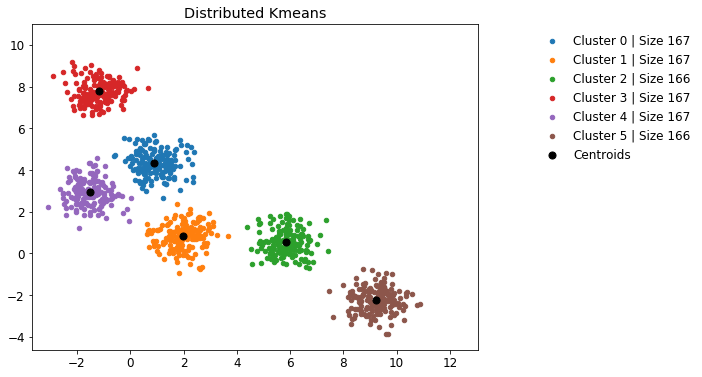

In [24]:
# Final cluster assignements:
distance_matrix = pairwise_distances(datapoints, centroids, metric='sqeuclidean')
# assign each data point to the closest centroid
cluster_assignment = np.argmin(distance_matrix, axis = 1)

plot_clusters(np.array(centroids), datapoints, cluster_assignment, title='Distributed Kmeans')

___

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Answer the following questions:
<br>
<br>
<ul>
    <li>How many partitions did you use? Why?</li>
    <li>What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?</li>
    <li>What is the size of the shuffle data over the network? How does it compare to the dataset size?</li>
</ul>
</div>

**Answer:**
___

In [ ]:
for partitions in [2,4,6,8,10,12]:
    start = time.clock()
    centroids = distributed_kmeans(datapoints, k=clusters, partitions=partitions, seed=0)
    end = time.clock()
    print('Partitions:', partitions, 'Computation Time:', end-start, 's')
    
# Partitions: 2 Computation Time: 2.706029000000001 s
# Partitions: 4 Computation Time: 2.8432229999999663 s
# Partitions: 6 Computation Time: 0.588483999999994 s
# Partitions: 8 Computation Time: 0.7646010000000274 s
# Partitions: 10 Computation Time: 1.625304999999969 s
# Partitions: 12 Computation Time: 1.2196280000000002 s

<div class="alert alert-block alert-success">
The cluster is composed of 2 workers each with 3 cores (6 cores in total). In the current configuration (1000 data points = small amount of data not using all RAM), the best option is 6 partitions. That is ensuring that all cores are used for computation. The best computation time is obtained when the computation is equally distributed accross the number of cores, it means with the current cluster having a number of partitions multiple of 6.
</div>

In [ ]:
for samples in [100,1000,10000,100000]:
        datapoints, y = make_blobs(n_samples=samples, centers=4, random_state=0, cluster_std=0.6)
        start = time.clock()
        centroids = distributed_kmeans(datapoints, k=clusters, seed=0) #partitions=6 by default
        end = time.clock()
        print("Samples:", samples, "Data size:", sys.getsizeof(datapoints)/1024, "KB", 
              "Computation Time:", end-start, 's')



Samples: 100 Data size: 1.671875 KB Computation Time: 1.428049999999999 s
Samples: 1000 Data size: 15.734375 KB Computation Time: 0.47474400000000117 s
Samples: 10000 Data size: 156.359375 KB Computation Time: 0.6655450000000016 s


<div class="alert alert-block alert-success">
Calling cache method prevent the RDD from being re-evaluated each time a method is used on it. Once cached the RDD is accessible by every nodes without reloading from disk the content. Here the Content comes from memory (make blobs) not disk, so re-evaluating the RDD is not IO expensive. Moreover the size of the dataset generated (with make blobs) is manageable by the nodes. The RAM occupation is 29 KB for each worker; it's possibile to see that on the Spark UI.
    
Caching is only usefull to reduce IO from disk in case dataset are really big. It prevents then the nodes to read from the disk but to directly retrieve the evaluated RDD from RAM. In our case caching is not really helpfull since we do not read from the disk.
</div>


___

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size you chose for your experiments, answer the following questions:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>
    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
</ul>
</div>

**Answer:**
___

- Which is "faster", the serial or distributed implementation of k-means?

<div class="alert alert-block alert-success">
On small datasets the faster version is clearly the serial implementation (because is doesnt need to shuffle accross the nodes). However on big dataset the distributed implementation is by far more faster. The distributed implementation comes with a chunk of heavy operation such as shuffling, partitionned data, IO on workers, that are a burden when dealling with small datasets compared to the serial implementation.

There is a tradoff between the implementation and the size of the dataset.
</div>

- What is a dataset size for which the distributed implementation is clearly faster than the serial one?

<div class="alert alert-block alert-success">
For big dataset (with size greater than serial machine RAM) the distributed version will be faster. Distributed implementation is better at dealing with this kind of load since it will be balanced accross the nodes of the network. In this case with dataset size more than 100 000 points the distributed version is faster.
</div>

- What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?

<div class="alert alert-block alert-success">
If the dataset resides on disk (not our case in the notebook), the RDD would be reading from the HDFS and trigger multiple IO each time an operation on the RDD is triggered. The solution to avoid triggering multiple IO while interracting with the RDD accross the clusters of nodes is to use caching (RDD.cache()).
Whitout cache the RDD is only evaluated when operation are applied (and if data is on disk it will trigger disk IO), with RDD.cache() the dataset (RDD) is evaluated only once and kept in memory.
    
Then regarding partiationing, it might be necessary to use repartition() to ensure a good load balancing.
</div>

